# Word2Vec Analysis

Given that word embeddings are used to help show the context of words, can Word2Vec be used to help build a literary of a fingerprint that could detect the writing of a specific author if it is given a corpus of their work? If this could this be used to identify the writing styles of the foreighn political influencers in the 2016 election and help to identify future attempts to meddle under new user keys?

To test this hypothesis I built W2V models for several authors identified in the 2016 election and compared their scores using the cosine similiarity of each shared word embedding in their vercor space. I then preformed some analysis on the results to help assess their validity.  

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import seaborn as sns

from bs4 import BeautifulSoup
import regex as re
import nltk

from gensim.models.word2vec import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from collections import defaultdict
from nltk.corpus import stopwords

In [2]:
# importing the cleaned tweet dataset
w2v_tweets = pd.read_csv('./datasets/cleaned_tweets.csv')
# rsetting it to a datetime index
w2v_tweets['date'] = w2v_tweets.date.map(lambda date: dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S'))
# set date column as index
w2v_tweets.set_index('date', inplace=True)
# reorder index by date
w2v_tweets.sort_index(inplace=True)

In [3]:
# defining the masks to filer the target tweets
english_mask = w2v_tweets.lang == 'en'
high_volume_mask = w2v_tweets.high_volume_user
retweet_mask = w2v_tweets.retweet

**Isolating Original Tweets From High Volume Users Written in English**

In [4]:
w2v_tweets = w2v_tweets.loc[english_mask & high_volume_mask & ~retweet_mask]
w2v_tweets.shape

(30108, 7)

In [5]:
w2v_tweets.head()

,user_key,text,cleaned_text,hashtags,lang,high_volume_user,retweet
date,,,,,,,
2014-07-14 18:04:55,evagreen69,I am in Love with LOVE!,i am in love with love,[],en,True,False
2014-07-20 06:30:01,heyits_toby,"True tolerance does not consist in saying, ""Yo...",true tolerance does not consist in saying you ...,[],en,True,False
2014-07-20 07:02:33,heyits_toby,oh and Ur in a position to judge me because? t...,oh and ur in a position to judge me because tw...,[],en,True,False
2014-07-23 13:26:32,heyits_toby,Today's weather forecast: Severe case of PMS w...,today s weather forecast severe case of pms wi...,[],en,True,False
2014-07-25 18:05:36,heyits_toby,has lost their sanity... Oh wait... No... It w...,has lost their sanity oh wait no it was never ...,[],en,True,False


In [6]:
# this is ultimately not a lot of text for w2v, let's see how the top 2 perform
w2v_tweets.user_key.value_counts(ascending=False).head(10)

thefoundingson    2981
ten_gop           2975
tpartynews        1455
pamela_moore13    1274
puredavie         1093
cassieweltch      1092
mr_clampin         891
giselleevns        884
ryanmaxwell_1      837
notritahart        834
Name: user_key, dtype: int64

Before going further, lets see if our corpus contain enough samples for W2V features to be used as a classification technique with any reasonalby accuarcy above the baseline. 

**Splitting by user_key and processing text**

In [7]:
# preparing text for word 2 vec
# we could also remove @user tags, but since they are part of the language of twitter, we will leave them in
def process_text(raw_text):
    # removing web links
    text = re.sub(r' https:[^\s]+', repl='', string=raw_text)
    text = re.sub(r' http:[^\s]+', repl='', string=text)
    text = re.sub(r'https:[^\s]+', repl='', string=text)
    text = re.sub(r'http:[^\s]+', repl='', string=text)
    # remove hashtags
    text = re.sub(r'\B#\w\w+', repl='', string=text)
    # removing any html artifacts
    text = BeautifulSoup(text, 'lxml').get_text().lower() 
    # removing any undesireable punctuation
    text = re.sub('[^0-9A-Za-z!?]+', repl=' ', string=text)
    # formatting for w2v
    return nltk.word_tokenize(text)

In [8]:
w2v_tweets['processed_text'] = w2v_tweets.cleaned_text.map(process_text)

In [9]:
# filtering tweets from the two highest-tweeting users 
testing_corpus = w2v_tweets.loc[(w2v_tweets.user_key=='thefoundingson') | (w2v_tweets.user_key=='ten_gop')]

# preparing their text for the W2V models
testing_corpus['processed_text'] = testing_corpus.text.map(process_text)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


**Building The Models**

In [10]:
# defining a function to quickly build models with default features
def build_w2v(sentences, num_features=300, min_word_count = 3, context=6, downsampling = 1e-3):
    
    W2Vmodel = Word2Vec(sentences=sentences,
                        sg=1,
                        hs=0,
                        size=num_features,
                        min_count=min_word_count,
                        window=context,
                        sample=downsampling,
                        negative=5,
                        iter=6)
    return W2Vmodel

In [11]:
%%time
# Initialize and train the model
testing_corpus_W2Vmodel = build_w2v(testing_corpus.processed_text)

CPU times: user 3.89 s, sys: 16.7 ms, total: 3.9 s
Wall time: 1.53 s


**Appending Features to Dataframe**

In [12]:
# modified from function viewed on kaggle kernel 
# https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = sentence_group  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, 
    # add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
# setting W2V features
testing_corpus['w2v_features'] = testing_corpus.processed_text.map(lambda text:
                                      get_w2v_features(testing_corpus_W2Vmodel, text))

**Setting feature columns**

In [15]:
testing_corpus['target'] = testing_corpus.user_key.map(lambda x: 1 if x == 'thefoundingson' else 0)

In [16]:
X = np.array(list(map(np.array, testing_corpus.w2v_features)))
y = testing_corpus.target

In [17]:
# checking the baseline
y.value_counts(normalize=True)

1    0.500504
0    0.499496
Name: target, dtype: float64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Testing with Naive Bayes**

In [19]:
from sklearn.naive_bayes import GaussianNB

In [20]:
gb = GaussianNB()

In [21]:
gb.fit(X_train, y_train)

GaussianNB(priors=None)

In [22]:
gb.score(X_train, y_train)

0.7062905753301992

In [23]:
y_pred = gb.predict(X_test)
accuracy_score(y_test, y_pred)

0.6924110141034251

---

# Word2Fingrepirnt - Cosine Similarity

To compare the cosine similarity of each author, two functions were built. The first calculates the average cosine similarity of all shared word embeddings in the two corpora being compared. The second takes in a list of authors and their respective corpora, builds W2V models for them, and compares their similiarity to a specified target author.

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
def get_w2v_cosine_similarity(w2v_model_1, w2v_model_2):
    
    model_1_words = set(w2v_model_1.wv.vocab.keys())  # words known to first model
    model_2_words = set(w2v_model_2.wv.vocab.keys())  # words known to second model
    
    # Initialize a counter for number of words in a review
    cosines = []
    # Loop over each word in the comment and, if it is in the model's vocabulary, 
    # add its cosine sim value to the list
    for word in model_1_words:
        if word in model_2_words: 
            cosines.append(cosine_similarity(w2v_model_1[word].reshape(1, -1), 
                                             w2v_model_2[word].reshape(1, -1)))

    # return the average of all cosine scores and the number of similar words
    return (np.array(cosines).mean(), len(cosines))

In [26]:
def cosine_dataframe(data, authors, target_author):
    # build a sekelton for the df with columns and a for for each author being compared
    df = pd.DataFrame(columns = ['user_key', 'cosine_sim', 'words'], index = range(len(authors)))
    # process the target author text and build the W2v Model
    target_author_text = data.text.loc[data.user_key == target_author].map(process_text)
    target_W2Vmodel = build_w2v(sentences=target_author_text)
    
    # iterating through each author
    for i in range(len(authors)):
        
        # process the author's text and build the w2v model
        author_text = data.text.loc[data.user_key == authors[i]].map(process_text)
        W2Vmodel = build_w2v(sentences=author_text)
        # calculate their avg cosine similarity and number of words
        cosine, words = get_w2v_cosine_similarity(target_W2Vmodel, W2Vmodel)
        # add the scores, words, and author name to the dataframe
        df.iloc[i] = [authors[i], round(cosine, 3), words]
        
    return(df.sort_values(by='cosine_sim', axis=0, ascending=False))

In [27]:
authors = list(w2v_tweets.user_key.value_counts().head(10).keys())

cosine_dataframe(w2v_tweets, authors, 'thefoundingson')

,user_key,cosine_sim,words
0,thefoundingson,0.981,1638
2,tpartynews,0.806,763
3,pamela_moore13,0.79,739
8,ryanmaxwell_1,0.758,430
7,giselleevns,0.736,331
1,ten_gop,0.735,1041
9,notritahart,0.734,283
6,mr_clampin,0.729,310
4,puredavie,0.714,422
5,cassieweltch,0.7,374


**The authors fall within an approximate 10% range of similarity, lets dig further to see how reliable they are.**

# Testing Consistency

The first test will compare multiple users and see how decreasing shared word count impacts score and the standard deviation of results

In [28]:
def cosine_multiple_user_test(data, authors, target_author, n_trials, num_features=300):
    # building an empth data frame with a row for each author
    df = pd.DataFrame(index = range(len(authors)))
    # filling in the user_key column and setting the words, mean, and std columns as blank
    df['user_key'] = pd.Series(authors)
    df['words'] = 0
    df['mean'] = 0
    df['std'] = 0
    
    # build a row of zeros to filled in for each trial
    for t in range(n_trials):
        df[f'trial_{t+1}'] = 0
    
    # processing the target author text
    target_author_text = data.text.loc[data.user_key == target_author].map(process_text)
    
    for t in range(n_trials): 
        # building target w2v (new target w2v for each trial)
        target_W2Vmodel = build_w2v(sentences=target_author_text)
        
        # iterate through every author
        for i in range(len(authors)):
            # process author text
            author_text = data.text.loc[data.user_key == authors[i]].map(process_text)

            # Initialize and train the model
            W2Vmodel = build_w2v(sentences=author_text)
            # score similarity
            cosine, words = get_w2v_cosine_similarity(target_W2Vmodel, W2Vmodel)
            # add cosine score to the trial column and author row
            df.iloc[i, t+4] = [cosine]
            # if this is the first trial append the words to the words column
            if t == 0:
                df.iloc[i, t+1] = words
    
    # after the trials complete calculate the mean similarity and std for each author
    end = df.shape[1] + 1
    df['mean'] = df.iloc[:, 4:end].apply(lambda x: np.mean(x), axis = 1)
    df['std'] = df.iloc[:, 4:end].apply(lambda x: np.std(x), axis = 1)
        
    return(df.sort_values(by='words', axis=0, ascending=False).reset_index(drop=True))

In [29]:
authors = list(w2v_tweets.user_key.value_counts().head(15).keys())

cosine_trials_300d = cosine_multiple_user_test(data = w2v_tweets, 
                                               authors = authors, 
                                               target_author = 'thefoundingson', 
                                               n_trials = 10)

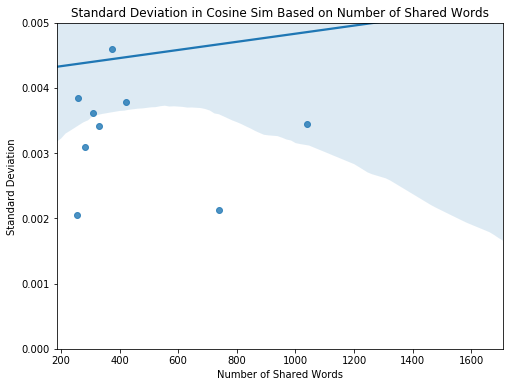

In [30]:
plt.figure(figsize=(8,6))
sns.regplot(cosine_trials_300d.words, cosine_trials_300d['std'])
plt.title("Standard Deviation in Cosine Sim Based on Number of Shared Words")
plt.ylabel('Standard Deviation')
plt.xlabel('Number of Shared Words')
plt.ylim([0, .005]);

# Testing Data Sensitivity 

The second test will compare one user to itself with different percentages of randomly selected texts, and record how limited data impacts the average cosine similarity. The test will be run with both unsorted and sorted data.

In [31]:
def cosine_same_user_test(data, n_trials, num_features=300, sort_data=True):
    
    df = pd.DataFrame(index = range(10))
    
    df['percentage'] = np.linspace(1, .1, 10)
    df['mean'] = 0
    df['std'] = 0
    
    original_W2Vmodel = build_w2v(sentences=data)
    
    for t in range(n_trials):
        df[f'trial_{t+1}'] = 0

    for t in range(n_trials): 
            
        for index, frac in enumerate(np.linspace(1, .1, 10)):
            # gives the ability to test results with sorted and unsorted data
            if sort_data:
                trial_text = data.sample(frac=frac, replace=False).sort_index()
            else:
                trial_text = data.sample(frac=frac, replace=False)

            trial_W2Vmodel = build_w2v(sentences=trial_text)

            cosine, words = get_w2v_cosine_similarity(original_W2Vmodel, trial_W2Vmodel)

            df.iloc[index, t+3] = [cosine]
    
    end = df.shape[1] + 1
    df['mean'] = df.iloc[:, 4:end].apply(lambda x: np.mean(x), axis = 1)
    df['std'] = df.iloc[:, 4:end].apply(lambda x: np.std(x), axis = 1)
        
    return df

Setting up thefoundingson corpus (as it has the most data) and running the test with both sorted and unsorted data.

In [32]:
thefoundingson_corpus = w2v_tweets.loc[w2v_tweets.user_key == 'thefoundingson']

In [33]:
cosine_same_user_trials_sorted = cosine_same_user_test(thefoundingson_corpus.processed_text, 
                                                       n_trials=10)
cosine_same_user_trials_unsorted = cosine_same_user_test(thefoundingson_corpus.processed_text, 
                                                         n_trials=10,
                                                         sort_data=False)

**Unsorted Results**

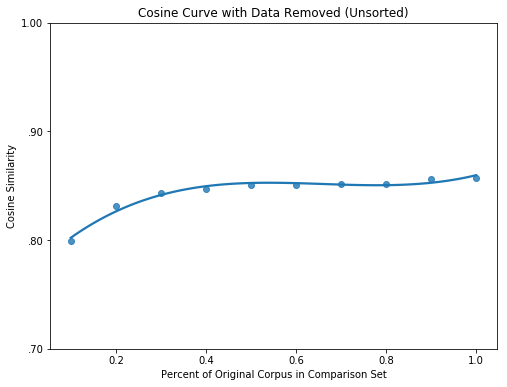

In [34]:
plt.figure(figsize=(8,6))
sns.regplot(cosine_same_user_trials_unsorted.percentage, 
            cosine_same_user_trials_unsorted['mean'].sort_values(ascending=False), 
            order=3, ci=None, truncate=True)
plt.title("Cosine Curve with Data Removed (Unsorted)")
plt.ylabel('Cosine Similarity')
plt.xlabel('Percent of Original Corpus in Comparison Set')
plt.xticks([.2, .4, .6, .8, 1])
plt.yticks([.7, .8, .9, 1], labels=['.70', '.80', '.90', '1.00']);

**Sorted results**

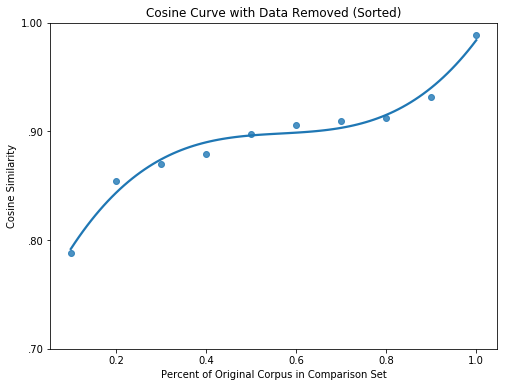

In [35]:
plt.figure(figsize=(8,6))
sns.regplot(cosine_same_user_trials_sorted.percentage, 
            cosine_same_user_trials_sorted['mean'].sort_values(ascending=False), 
            order=3, ci=None, truncate=True)
plt.title("Cosine Curve with Data Removed (Sorted)")
plt.ylabel('Cosine Similarity')
plt.xlabel('Percent of Original Corpus in Comparison Set')
plt.xticks([.2, .4, .6, .8, 1])
plt.yticks([.7, .8, .9, 1], labels=['.70', '.80', '.90', '1.00']);

The results from the missing data test wiht sorted and unosrtd data show that the order in which the Word2Vwc model learns words is important. This makes sense if we think about what the model is doing, building a vector space based on the context of the words it sees. What is important is how the word embeddings relate to each other, but there is no requirement that model build out in the same set of axes. Effectively, when we train two models on a random order of documents, we are projecting the same structure into two different versions of n-dimensional space with different coordinate systems. To solve this problem we would either need determine a method to align the unknown axes, compare relationships in the models through a scalar metric, or to set the initial conditions so that a model generates embeddings in the same coordinate system. 

**Testing Results on a Pretrained Model**

In [36]:
corpus_w2v = build_w2v(w2v_tweets.cleaned_text.map(process_text))

In [37]:
baseline_w2v = corpus_w2v

In [38]:
%%time
corpus_w2v.train(thefoundingson_corpus.processed_text, 
                 total_examples=len(thefoundingson_corpus),
                 epochs=corpus_w2v.iter)

CPU times: user 2.24 s, sys: 15.4 ms, total: 2.25 s
Wall time: 980 ms


(160195, 215466)

In [39]:
test_2 = baseline_w2v

In [40]:
ten_gop_corpus = w2v_tweets.loc[w2v_tweets.user_key == 'ten_gop']

In [41]:
test_2.train(ten_gop_corpus.processed_text,
             total_examples = len(ten_gop_corpus), 
             epochs=corpus_w2v.iter)

(199379, 256020)

In [42]:
get_w2v_cosine_similarity(corpus_w2v, baseline_w2v)

(1.0, 7443)

In [43]:
get_w2v_cosine_similarity(corpus_w2v, test_2)

(1.0, 7443)

Both tests show cosine scores of 1.0.

---

**Comparing average difference for cosine similarity in order to evaluate model similarity on a scalar value**

In [44]:
def get_w2v_cosine_similarity_diff(w2v_model_1, w2v_model_2):
    
    model_1_words = set(w2v_model_1.wv.vocab.keys())  # words known to first model
    model_2_words = set(w2v_model_2.wv.vocab.keys())  # words known to second model
    
    # Initialize a counter for number of words in a review
    diff = []
    # Loop over each word in the comment and, if it is in the model's vocabulary, 
    # add its cosine sim value to the list
    for word in model_1_words:
        if word in model_2_words: 
            dist_1 = (w2v_model_1['the'] - w2v_model_1[word])
            
            dist_2 = (w2v_model_2['the'] - w2v_model_2[word])
            
            diff.append(abs(dist_1 - dist_2))

    # return the average of all cosine scores and the number of similar words
    return (round(np.array(diff).mean(), 3), len(diff))

In [45]:
def cosine_diff_dataframe(data, authors, target_author):
    
    # build a sekelton for the df with columns and a for for each author being compared
    df = pd.DataFrame(columns = ['user_key', 'cosine_diff', 'words'], index = range(len(authors)))
    # process the target author text and build the W2v Model
    target_author_text = data.text.loc[data.user_key == target_author].map(process_text)
    target_W2Vmodel = build_w2v(sentences=target_author_text)
    
    # iterating through each author
    for i in range(len(authors)):
        
        # process the author's text and build the w2v model
        author_text = data.text.loc[data.user_key == authors[i]].map(process_text)
        W2Vmodel = build_w2v(sentences=author_text)
        # calculate their avg cosine similarity and number of words
        cosine_diff, words = get_w2v_cosine_similarity_diff(target_W2Vmodel, W2Vmodel)
        # add the scores, words, and author name to the dataframe
        df.iloc[i] = [authors[i], cosine_diff, words]
        
    return(df.sort_values(by='cosine_diff', axis=0).reset_index(drop=True))

In [46]:
def cosine_same_user_diff_test(data, n_trials, num_features=300, sort_data=True):
    
    df = pd.DataFrame(index = range(10))
    
    df['percentage'] = np.linspace(1, .1, 10)
    df['mean'] = 0
    df['std'] = 0
    
    original_W2Vmodel = build_w2v(sentences=data)
    
    for t in range(n_trials):
        df[f'trial_{t+1}'] = 0

    for t in range(n_trials): 
            
        for index, frac in enumerate(np.linspace(1, .1, 10)):
            # gives the ability to test results with sorted and unsorted data
            if sort_data:
                trial_text = data.sample(frac=frac, replace=False).sort_index()
            else:
                trial_text = data.sample(frac=frac, replace=False)

            trial_W2Vmodel = build_w2v(sentences=trial_text)

            cosine, words = get_w2v_cosine_similarity_diff(original_W2Vmodel, trial_W2Vmodel)

            df.iloc[index, t+3] = [cosine]
    
    end = df.shape[1] + 1
    df['mean'] = df.iloc[:, 4:end].apply(lambda x: np.mean(x), axis = 1)
    df['std'] = df.iloc[:, 4:end].apply(lambda x: np.std(x), axis = 1)
        
    return df

---

**Testing with Kaggle Data**

In [47]:
kaggle_df = pd.read_csv('./datasets/kaggle_authors.csv')

In [48]:
kaggle_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [49]:
kaggle_df['process_text'] = kaggle_df.text.map(process_text)

In [50]:
kaggle_df.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [51]:
eap_corpus = kaggle_df.loc[kaggle_df.author == 'EAP']
mws_corpus = kaggle_df.loc[kaggle_df.author == 'MWS']
hpl_corpus = kaggle_df.loc[kaggle_df.author == 'HPL']

In [52]:
eap_words = [token for text in eap_corpus.process_text for token in text]
mws_words = [token for text in mws_corpus.process_text for token in text]
hpl_words = [token for text in hpl_corpus.process_text for token in text]

print(f'Number of EAP words: {len(eap_words)}')
print(f'Number of Unique EAP words: {len(set(eap_words))}')
print()
print(f'Number of MWS words: {len(mws_words)}')
print(f'Number of Unique MWS words: {len(set(mws_words))}')
print()
print(f'Number of HPL words: {len(hpl_words)}')
print(f'Number of Unique HPL words: {len(set(hpl_words))}')

Number of EAP words: 202192
Number of Unique EAP words: 15278

Number of MWS words: 166555
Number of Unique MWS words: 11529

Number of HPL words: 157632
Number of Unique HPL words: 14526


In [53]:
cos_diff_test_unsorted = cosine_same_user_diff_test(eap_corpus.process_text, 
                                           n_trials=10,
                                           sort_data=False)

In [54]:
cos_diff_test_unsorted

,percentage,mean,std,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_7,trial_8,trial_9,trial_10
0,1.0,0.060778,0.002043,0.063,0.061,0.062,0.061,0.057,0.061,0.065,0.061,0.060,0.059
1,0.9,0.060667,0.003300,0.061,0.064,0.062,0.063,0.058,0.059,0.057,0.063,0.065,0.055
2,0.8,0.059778,0.001812,0.054,0.058,0.061,0.059,0.058,0.062,0.058,0.058,0.062,0.062
3,0.7,0.058556,0.002266,0.063,0.058,0.058,0.061,0.057,0.059,0.062,0.056,0.061,0.055
4,0.6,0.059889,0.002131,0.060,0.058,0.060,0.059,0.062,0.059,0.059,0.058,0.065,0.059
5,0.5,0.062222,0.001931,0.063,0.061,0.059,0.063,0.066,0.061,0.061,0.062,0.063,0.064
6,0.4,0.065222,0.001474,0.062,0.065,0.067,0.065,0.063,0.064,0.066,0.068,0.064,0.065
7,0.3,0.069556,0.000956,0.069,0.068,0.069,0.070,0.070,0.071,0.070,0.068,0.070,0.070
8,0.2,0.073444,0.000831,0.073,0.074,0.074,0.075,0.073,0.073,0.074,0.072,0.073,0.073
9,0.1,0.078111,0.000314,0.078,0.078,0.079,0.078,0.078,0.078,0.078,0.078,0.078,0.078


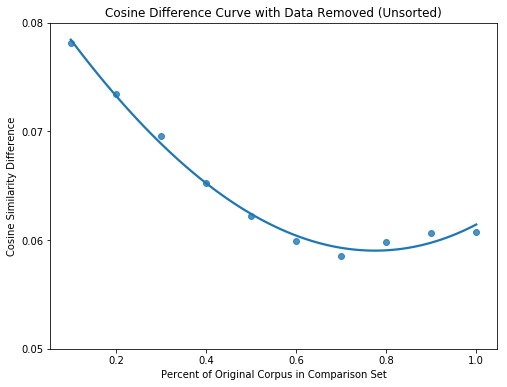

In [55]:
plt.figure(figsize=(8,6))
sns.regplot(cos_diff_test_unsorted.percentage, 
            cos_diff_test_unsorted['mean'], 
            order=3, ci=None, truncate=True)
plt.title("Cosine Difference Curve with Data Removed (Unsorted)")
plt.ylabel('Cosine Similarity Difference')
plt.xlabel('Percent of Original Corpus in Comparison Set')
plt.xticks([.2, .4, .6, .8, 1])
plt.yticks([.05, .06, .07, .08]);

In [56]:
cos_diff_test_sorted = cosine_same_user_diff_test(eap_corpus.process_text, 
                                           n_trials=10)

In [57]:
cos_diff_test_sorted

,percentage,mean,std,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_7,trial_8,trial_9,trial_10
0,1.0,0.038222,0.007997,0.046,0.048,0.033,0.028,0.048,0.040,0.032,0.047,0.027,0.041
1,0.9,0.060000,0.003367,0.063,0.056,0.058,0.059,0.065,0.065,0.061,0.059,0.055,0.062
2,0.8,0.062222,0.005266,0.062,0.068,0.064,0.057,0.067,0.055,0.068,0.057,0.067,0.057
3,0.7,0.063333,0.002539,0.061,0.063,0.060,0.062,0.064,0.062,0.066,0.060,0.065,0.068
4,0.6,0.060889,0.001969,0.063,0.057,0.063,0.063,0.063,0.059,0.061,0.060,0.062,0.060
5,0.5,0.064000,0.002944,0.069,0.064,0.062,0.066,0.061,0.065,0.069,0.063,0.067,0.059
6,0.4,0.067000,0.001563,0.064,0.066,0.068,0.068,0.067,0.064,0.068,0.069,0.068,0.065
7,0.3,0.069667,0.001764,0.066,0.070,0.071,0.070,0.071,0.071,0.070,0.071,0.066,0.067
8,0.2,0.072778,0.001133,0.073,0.073,0.072,0.073,0.074,0.072,0.073,0.075,0.072,0.071
9,0.1,0.077111,0.000567,0.077,0.077,0.077,0.078,0.077,0.076,0.078,0.077,0.077,0.077


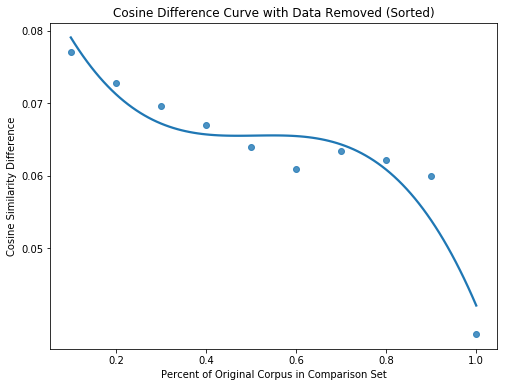

In [58]:
plt.figure(figsize=(8,6))
sns.regplot(cos_diff_test_sorted.percentage, 
            cos_diff_test_sorted['mean'], 
            order=3, ci=None, truncate=True)
plt.title("Cosine Difference Curve with Data Removed (Sorted)")
plt.ylabel('Cosine Similarity Difference')
plt.xlabel('Percent of Original Corpus in Comparison Set')
plt.xticks([.2, .4, .6, .8, 1])
plt.yticks([.05, .06, .07, .08]);

**Order matters even when accounting for coordinate system discripencies**

In [59]:
# training corpuses
eap_corpus_train = eap_corpus.iloc[:int(len(eap_corpus) // 1.25), :]
mws_corpus_train = mws_corpus.iloc[:int(len(mws_corpus) // 1.25), :]
hpl_corpus_train = hpl_corpus.iloc[:int(len(hpl_corpus) // 1.25), :]

# testing corpuses
eap_corpus_test = eap_corpus.iloc[int(len(eap_corpus) // 1.25):, :]
mws_corpus_test = mws_corpus.iloc[int(len(mws_corpus) // 1.25):, :]
hpl_corpus_test = hpl_corpus.iloc[int(len(hpl_corpus) // 1.25):, :]

In [60]:
%%time

# w2v models
eap_w2v_train = build_w2v(eap_corpus_train.process_text)
mws_w2v_train = build_w2v(mws_corpus_train.process_text)
hpl_w2v_train = build_w2v(hpl_corpus_train.process_text)

eap_w2v_test = build_w2v(eap_corpus_test.process_text)
mws_w2v_test = build_w2v(mws_corpus_test.process_text)
hpl_w2v_test = build_w2v(hpl_corpus_test.process_text)

CPU times: user 28.2 s, sys: 102 ms, total: 28.3 s
Wall time: 11 s


---

Testing cosine difference on spooky author data.

In [72]:
get_w2v_cosine_similarity_diff(eap_w2v_train, eap_w2v_test)

(0.065, 1751)

In [62]:
get_w2v_cosine_similarity_diff(eap_w2v_train, mws_w2v_test)

(0.065, 1322)

In [63]:
get_w2v_cosine_similarity_diff(eap_w2v_train, hpl_w2v_test)

(0.066, 1248)

In [64]:
get_w2v_cosine_similarity_diff(eap_w2v_train, mws_w2v_train)

(0.061, 2772)

In [65]:
get_w2v_cosine_similarity_diff(eap_w2v_train, hpl_w2v_train)

(0.063, 2804)

In [66]:
get_w2v_cosine_similarity_diff(eap_w2v_train, eap_w2v_train)

(0.0, 5529)

All authors converge to a similar score and the EPA test group is unable to be differentiated from the other authors.